In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from math import sqrt
from scipy.stats import pearsonr, spearmanr

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LassoLars, LinearRegression, TweedieRegressor

import acquire
import prepare
import explore
import model

%matplotlib inline
pd.options.display.max_columns = None

import warnings
warnings.filterwarnings("ignore")

seed = 42

# acquire

In [2]:
df = acquire.get_zillow()

In [3]:
df.head()

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,10804942,3.0,2.0,1175.0,327859.0,1953.0,4050.73,6037.0
1,14207926,3.0,2.0,1630.0,63948.0,1953.0,852.29,6037.0
2,10986950,2.0,2.0,1206.0,356218.0,1954.0,4393.33,6037.0
3,14207492,3.0,2.0,1790.0,242773.0,1964.0,3037.37,6037.0
4,11147606,3.0,2.0,1400.0,251246.0,1953.0,3081.31,6037.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56080 entries, 0 to 56079
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      56080 non-null  int64  
 1   bedroomcnt                    56080 non-null  float64
 2   bathroomcnt                   56080 non-null  float64
 3   calculatedfinishedsquarefeet  55849 non-null  float64
 4   taxvaluedollarcnt             56072 non-null  float64
 5   yearbuilt                     55831 non-null  float64
 6   taxamount                     55950 non-null  float64
 7   fips                          56080 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 3.4 MB


In [5]:
df.isna().sum()

parcelid                          0
bedroomcnt                        0
bathroomcnt                       0
calculatedfinishedsquarefeet    231
taxvaluedollarcnt                 8
yearbuilt                       249
taxamount                       130
fips                              0
dtype: int64

# prepare

In [6]:
df = prepare.prep_zillow(df)

In [7]:
cols = ['bedrooms', 'bathrooms', 'sqft', 'yearbuilt', 'fips']

In [106]:
prepare.remove_outliers(df, 2.25, cols)

,bedrooms,bathrooms,sqft,tax_value,yearbuilt,fips
0,3.0,2.0,1175.0,327859.0,1953.0,6037.0
1,3.0,2.0,1630.0,63948.0,1953.0,6037.0
2,2.0,2.0,1206.0,356218.0,1954.0,6037.0
3,3.0,2.0,1790.0,242773.0,1964.0,6037.0
4,3.0,2.0,1400.0,251246.0,1953.0,6037.0
...,...,...,...,...,...,...
56075,3.0,2.0,1400.0,318206.0,1951.0,6037.0
56076,4.0,2.0,1446.0,140804.0,1951.0,6037.0
56077,4.0,2.0,1584.0,412114.0,1955.0,6037.0
56078,4.0,2.0,1584.0,186627.0,1955.0,6037.0


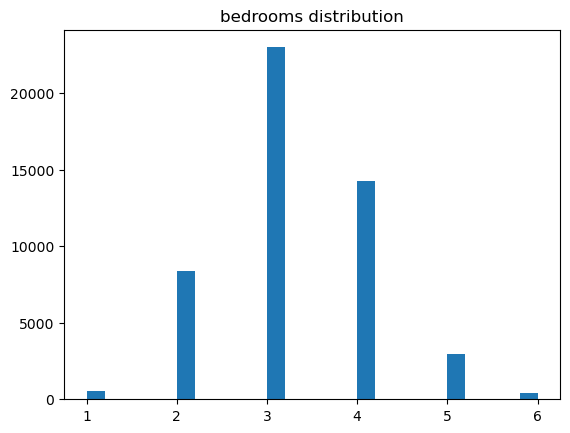

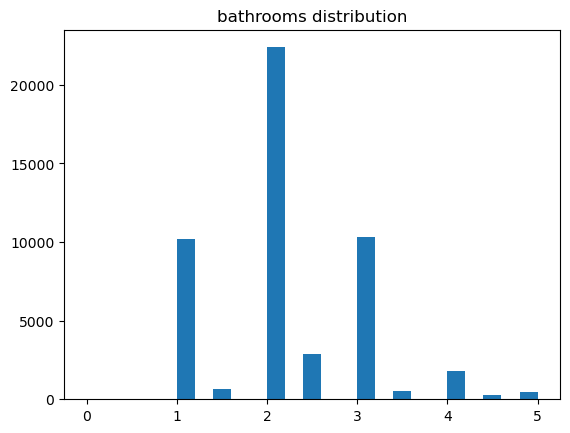

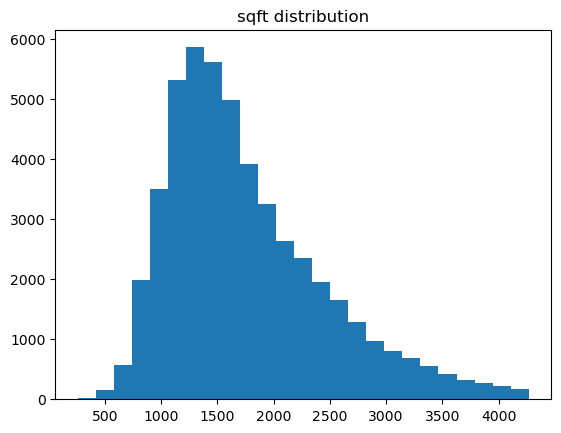

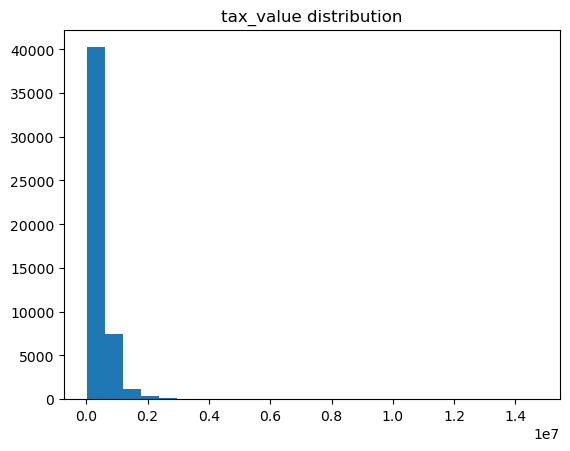

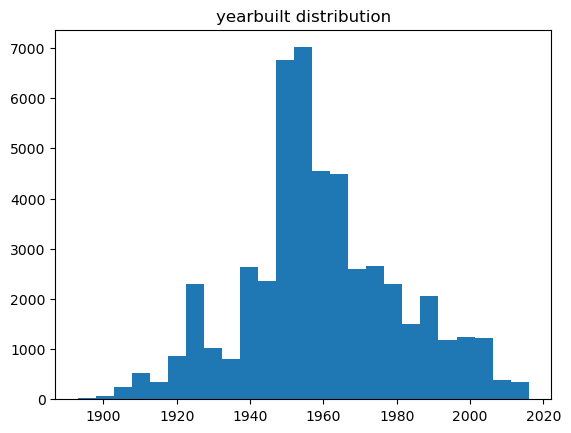

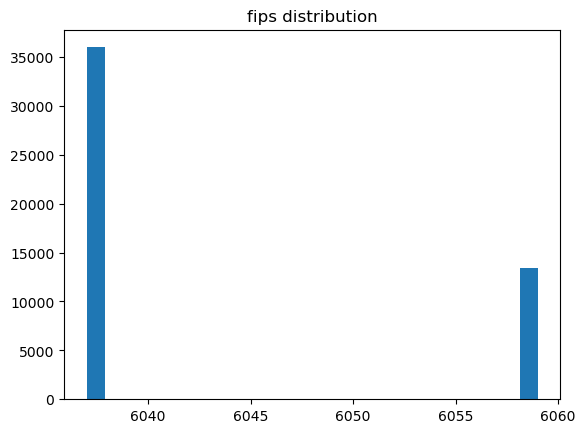

In [9]:
for col in df:

    plt.hist(df[col], bins=25)
    plt.title(f'{col} distribution')
    plt.show()

In [10]:
train, validate, test = prepare.subset_df(df)
train.shape, validate.shape, test.shape

(29676, 6) (9892, 6) (9892, 6)


((29676, 6), (9892, 6), (9892, 6))

# explore

q1 - Do bedroom and bathroom counts have a relationship?


In [11]:
train.head()

,bedrooms,bathrooms,sqft,tax_value,yearbuilt,fips
42956,4.0,3.0,3023.0,386000.0,2005.0,6037.0
32660,3.0,3.5,2319.0,557838.0,1987.0,6059.0
38800,3.0,3.0,2269.0,954293.0,1927.0,6037.0
35939,3.0,2.0,1710.0,375081.0,1965.0,6037.0
33312,3.0,2.5,1997.0,685293.0,1992.0,6059.0


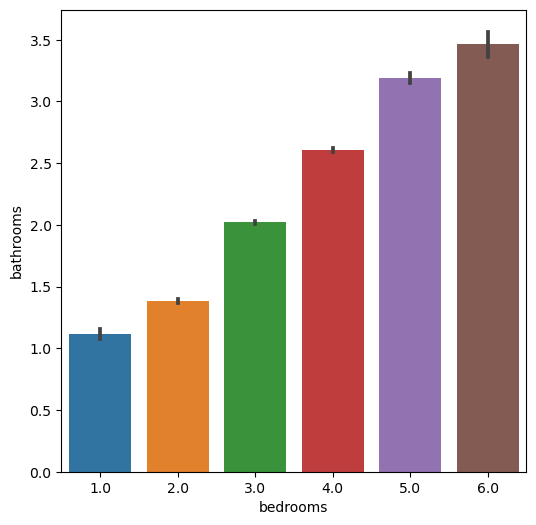

In [12]:
plt.figure(figsize=(6,6))
sns.barplot(x='bedrooms', y='bathrooms', data=train)
plt.show()

There seems to be a relationship between bedrooms and bathrooms, as expected, the more bedrooms a house has, the more bathrooms.

q2 - Does year built have an effect on the number of bedrooms?


<AxesSubplot:xlabel='bedrooms', ylabel='yearbuilt'>

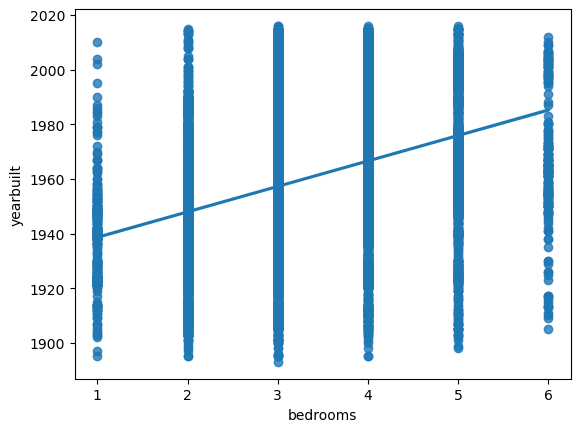

In [107]:
sns.regplot(x='bedrooms', y='yearbuilt', data=train)

<AxesSubplot:xlabel='bedrooms', ylabel='yearbuilt'>

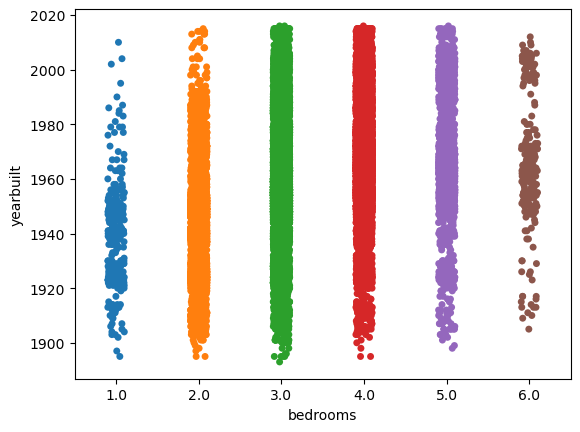

In [111]:
sns.stripplot(x='bedrooms', y='yearbuilt', data=train)

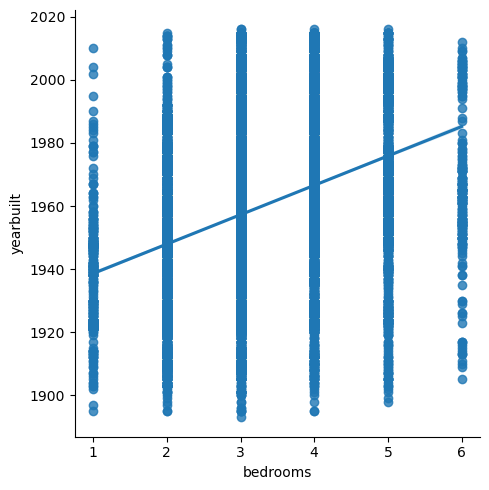

In [109]:
sns.lmplot(x='bedrooms', y='yearbuilt', data=train)

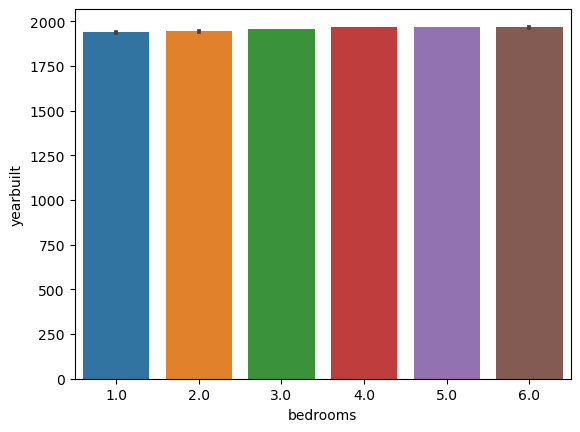

In [13]:
sns.barplot(x='bedrooms', y='yearbuilt', data=train)

plt.show()

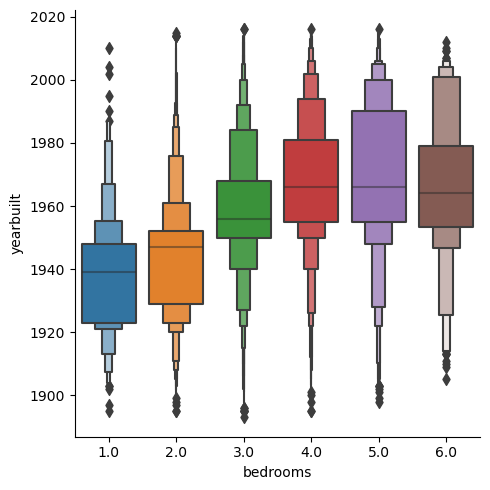

In [119]:
sns.catplot(x='bedrooms', y='yearbuilt', kind='boxen', data=train)

q3 - Does year built have a relationship with the square feet of the house? spearmanr test


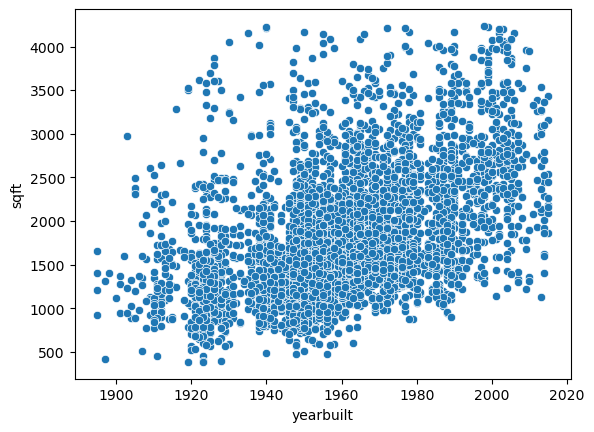

In [14]:
sns.scatterplot(x='yearbuilt', y='sqft', data=train.sample(5000))

plt.show()

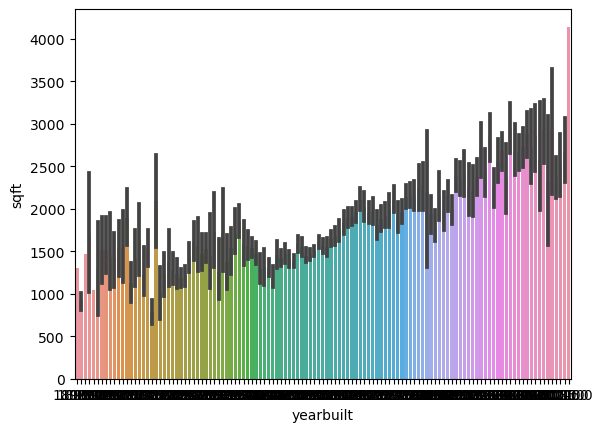

In [15]:
sns.barplot(x='yearbuilt', y='sqft', data=train.sample(5000))
plt.show()

In [16]:
cols = ['sqft', 'yearbuilt']

<AxesSubplot:>

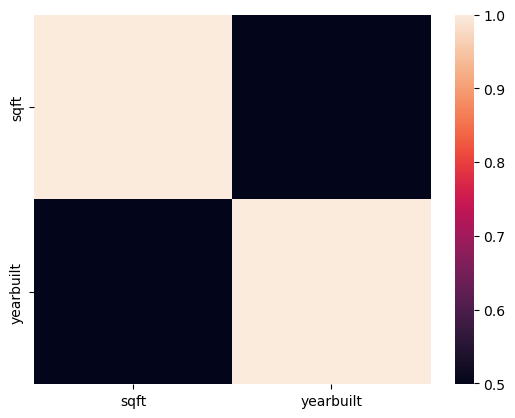

In [17]:
train_corr = train[cols].corr(method='spearman')
sns.heatmap(train_corr)

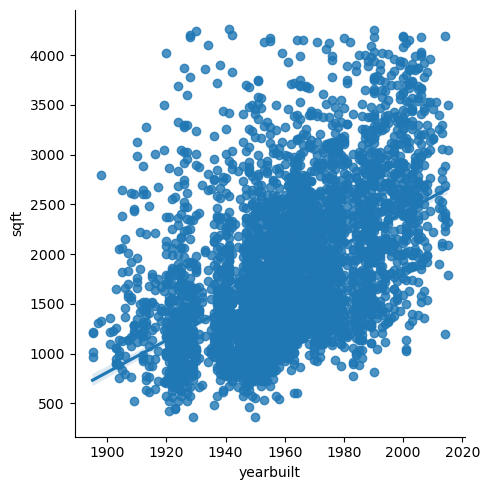

In [18]:
sns.lmplot('yearbuilt', 'sqft', data=train.sample(5000))

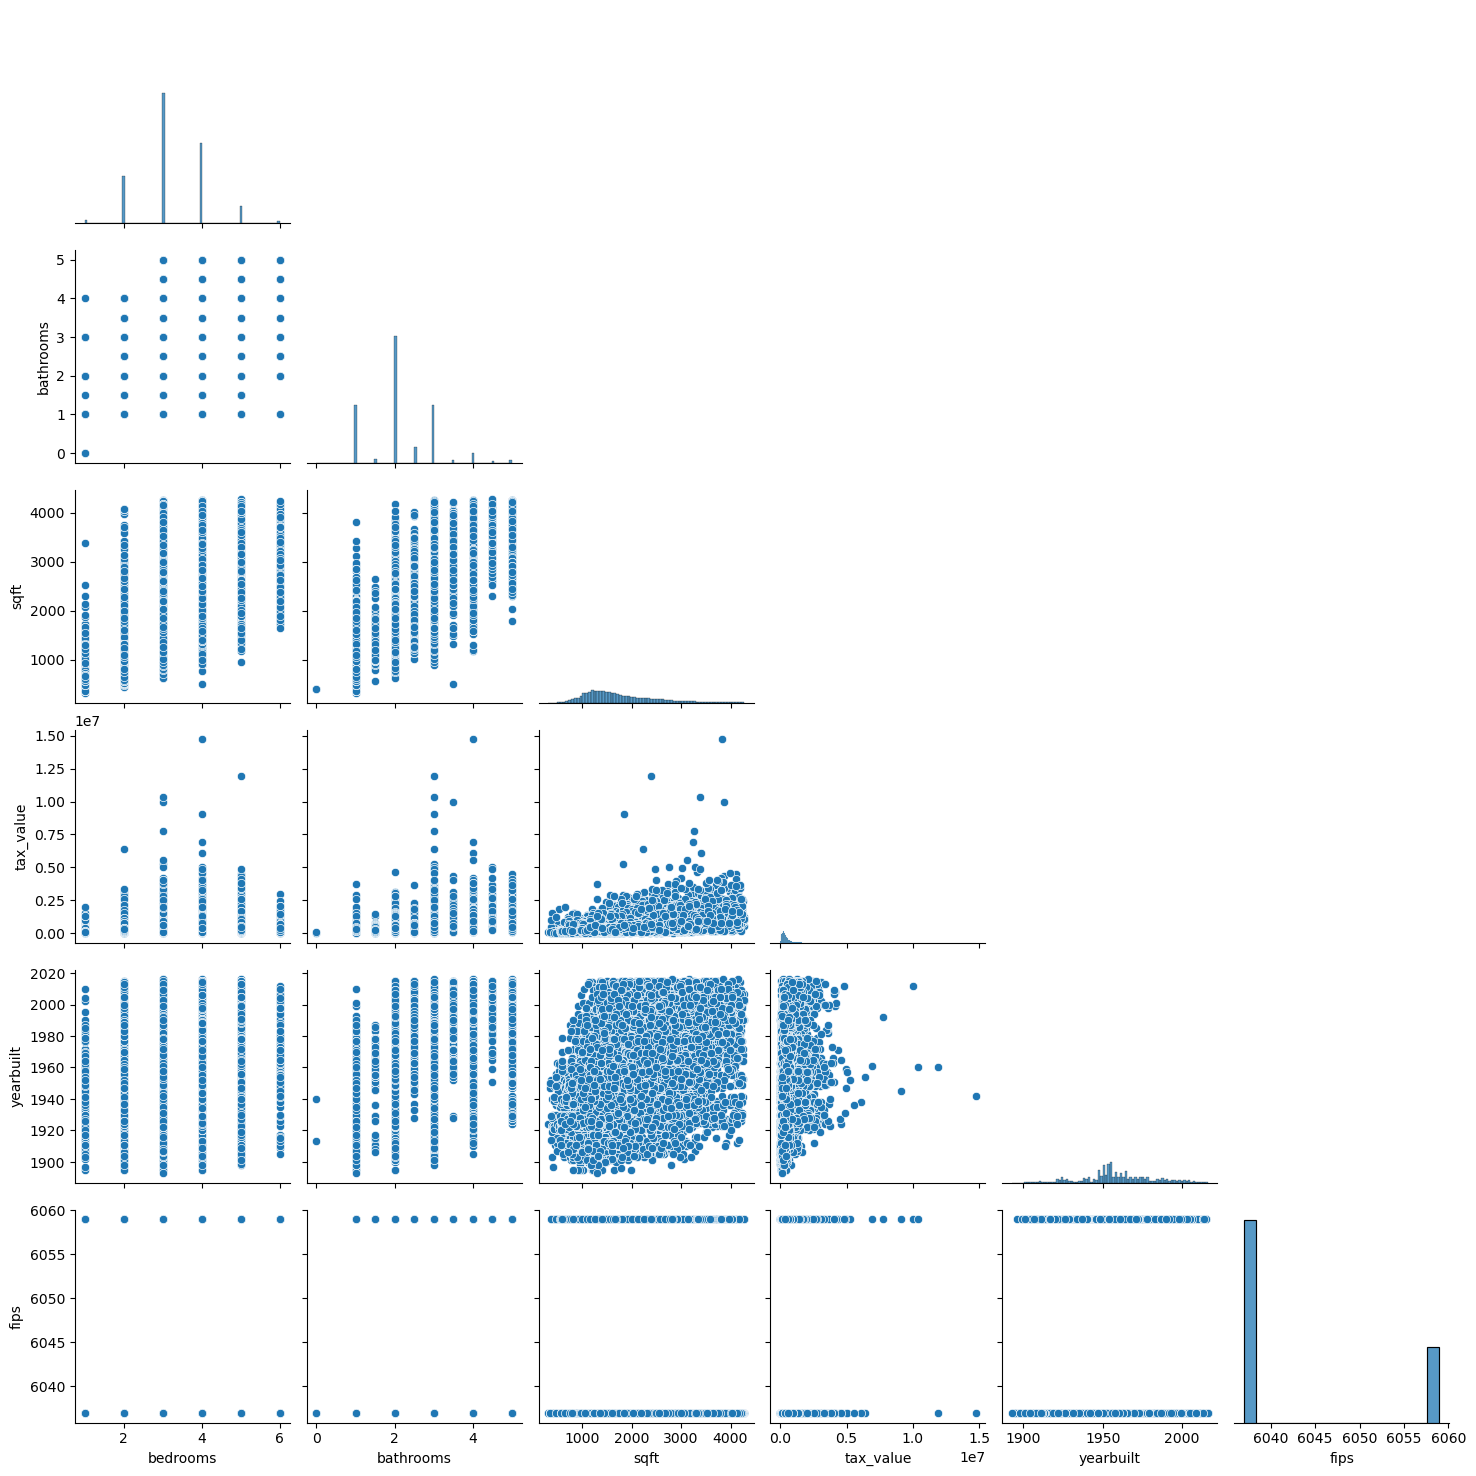

In [19]:
sns.pairplot(train, corner=True)

In [20]:
alpha = .05

In [21]:
corr, p = stats.pearsonr(train['sqft'], train['yearbuilt'])

corr, p

(0.4770610987323474, 0.0)

q4 - Does fips have a relationship with the square feet? chi2 test


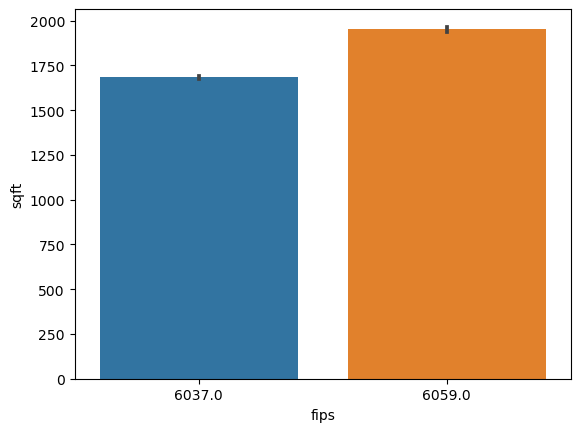

In [22]:
sns.barplot(x='fips', y='sqft', data=train)

plt.show()

In [23]:
alpha = .05

In [24]:
statistic, p = stats.mannwhitneyu(train['fips'], train['sqft'])
statistic, p

(880664976.0, 0.0)

In [25]:
t, p = stats.ttest_ind(train['fips'], train['sqft'], equal_var=False)
t, p 

(1053.2677739122134, 0.0)

I ended up running an independent t-test and a mann whitney u test to confirm a relationship, and it does seem like there is a relationship between fips and square feet.

q5 - Is there a relationship between bathrooms and fips?


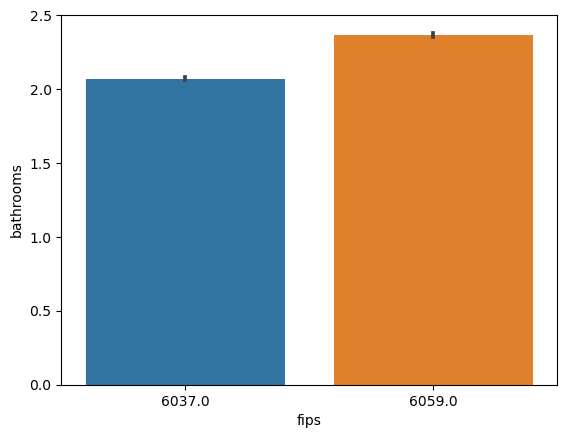

In [26]:
sns.barplot(x='fips', y='bathrooms', data=train)

plt.show()

In [27]:
chi2, p = explore.chi2_report(train, 'fips', 'bathrooms')

Observed Values

[[    2  5595     0 10209     0  4665     0   884     0   240]
 [    0   524   391  3259  1709  1518   312   181   165    22]]
---
Expected Values

[[   1 4452  284 9800 1243 4499  227  774  120  190]
 [   0 1666  106 3667  465 1683   84  290   44   71]]
---

chi^2 = 8151.4849
p     = 0.0000
Is p-value < alpha? True


TypeError: cannot unpack non-iterable NoneType object

There does seem to be something of a relationship between fips and number of bathrooms in homes

# Feature engineering

In [41]:
train.shape, validate.shape, test.shape

((29676, 6), (9892, 6), (9892, 6))

In [43]:
X_train, y_train, X_validate, y_validate, X_test, y_test = model.xy_subsets(train, validate, test, 'tax_value')

In [44]:
X_train

,bedrooms,bathrooms,sqft,yearbuilt,fips
42956,4.0,3.0,3023.0,2005.0,6037.0
32660,3.0,3.5,2319.0,1987.0,6059.0
38800,3.0,3.0,2269.0,1927.0,6037.0
35939,3.0,2.0,1710.0,1965.0,6037.0
33312,3.0,2.5,1997.0,1992.0,6059.0
...,...,...,...,...,...
13282,2.0,1.0,1610.0,1911.0,6037.0
50350,3.0,2.5,1669.0,1954.0,6059.0
43615,3.0,2.5,1266.0,1990.0,6059.0
882,3.0,2.0,1850.0,1958.0,6037.0


In [49]:
cols = ['sqft', 'yearbuilt']

X_train_scaled, X_validate_scaled, X_test_scaled = prepare.scale_data(X_train, X_validate, X_test, MinMaxScaler(), cols)

In [53]:
X_train_scaled = pd.get_dummies(X_train_scaled, columns=['bedrooms', 'bathrooms', 'fips'])

In [54]:
X_train_scaled

,sqft,yearbuilt,bedrooms_1.0,bedrooms_2.0,bedrooms_3.0,bedrooms_4.0,bedrooms_5.0,bedrooms_6.0,bathrooms_0.0,bathrooms_1.0,bathrooms_1.5,bathrooms_2.0,bathrooms_2.5,bathrooms_3.0,bathrooms_3.5,bathrooms_4.0,bathrooms_4.5,bathrooms_5.0,fips_6037.0,fips_6059.0
42956,0.684824,0.910569,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
32660,0.506461,0.764228,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
38800,0.493793,0.276423,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
35939,0.352166,0.585366,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
33312,0.424880,0.804878,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13282,0.326831,0.146341,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
50350,0.341779,0.495935,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
43615,0.239676,0.788618,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
882,0.387636,0.528455,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


# modeling

## basic linear regression model

In [55]:
lm = LinearRegression()

lm.fit(X_train_scaled, y_train)

lm_preds = lm.predict(X_train_scaled)

preds_df = pd.DataFrame({'actual': y_train,
                         'lm_preds': lm_preds})

In [59]:
preds_df['baseline_avg'] = y_train.mean()

In [57]:
sqrt(mean_squared_error(preds_df['actual'], preds_df['baseline_avg']))

405333.88847892865

In [62]:
preds_df = preds_df.drop(columns=['baseline_median'])

In [63]:
preds_df

,actual,lm_preds,baseline_avg
42956,386000.0,661536.0,408646.073965
32660,557838.0,831120.0,408646.073965
38800,954293.0,608736.0,408646.073965
35939,375081.0,370528.0,408646.073965
33312,685293.0,490192.0,408646.073965
...,...,...,...
13282,340909.0,445760.0,408646.073965
50350,105389.0,444176.0,408646.073965
43615,585076.0,291472.0,408646.073965
882,604381.0,417120.0,408646.073965


In [64]:
lm_rmse = sqrt(mean_squared_error(preds_df['lm_preds'], preds_df['actual']))

lm_rmse

342433.9784365328

## basic lasso-lars model

In [86]:
lasso = LassoLars(alpha=.1)

lasso.fit(X_train_scaled, y_train)

lasso_preds = lasso.predict(X_train_scaled)

preds_df['lasso_preds'] = lasso_preds

preds_df.head()

,actual,lm_preds,baseline_avg,lasso_preds
42956,386000.0,661536.0,408646.073965,690818.544404
32660,557838.0,831120.0,408646.073965,737297.854706
38800,954293.0,608736.0,408646.073965,547023.888315
35939,375081.0,370528.0,408646.073965,379457.320343
33312,685293.0,490192.0,408646.073965,476293.752166


In [87]:
lasso_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['lasso_preds']))
lasso_rmse

343857.3180028407

## polynomial regression

In [88]:
pf = PolynomialFeatures(degree=2)

pf.fit(X_train_scaled, y_train)

X_polynomial = pf.transform(X_train_scaled)

### linear regression with polynomial

In [89]:
lm2 = LinearRegression()

lm2.fit(X_polynomial, y_train)

preds_df['poly_preds'] = lm2.predict(X_polynomial)

preds_df.head()

,actual,lm_preds,baseline_avg,lasso_preds,poly_preds
42956,386000.0,661536.0,408646.073965,690818.544404,588672.0
32660,557838.0,831120.0,408646.073965,737297.854706,809216.0
38800,954293.0,608736.0,408646.073965,547023.888315,649600.0
35939,375081.0,370528.0,408646.073965,379457.320343,344832.0
33312,685293.0,490192.0,408646.073965,476293.752166,554752.0


In [90]:
lm2_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['poly_preds']))

lm2_rmse

337680.1082911183

### lasso-lars with polynomial

In [ ]:
lasso2 = LassoLars(alpha=.33)

lasso2.fit(X_polynomial, y_train)

lasso2_preds = lasso2.predict(X_polynomial)

preds_df['lasso_poly'] = lasso2_preds

In [100]:
preds_df.head()

,actual,lm_preds,baseline_avg,lasso_preds,poly_preds,lasso_poly,tweedie_norm_preds
42956,386000.0,661536.0,408646.073965,690818.544404,588672.0,667217.948830,463571.049193
32660,557838.0,831120.0,408646.073965,737297.854706,809216.0,819064.442421,441703.018387
38800,954293.0,608736.0,408646.073965,547023.888315,649600.0,542907.865952,425951.533601
35939,375081.0,370528.0,408646.073965,379457.320343,344832.0,352103.228631,380358.151966
33312,685293.0,490192.0,408646.073965,476293.752166,554752.0,488167.390914,437304.730497


In [96]:
lasso2_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['lasso_poly']))

lasso2_rmse

340455.65871630085

## glm 

### normal distribution

In [101]:
tweedie = TweedieRegressor(power=0)

tweedie.fit(X_train_scaled, y_train)

tweedie_preds = tweedie.predict(X_train_scaled)

preds_df['tweedie_norm_preds'] = tweedie_preds

preds_df.head()

,actual,lm_preds,baseline_avg,lasso_preds,poly_preds,lasso_poly,tweedie_norm_preds
42956,386000.0,661536.0,408646.073965,690818.544404,588672.0,667217.948830,463571.049193
32660,557838.0,831120.0,408646.073965,737297.854706,809216.0,819064.442421,441703.018387
38800,954293.0,608736.0,408646.073965,547023.888315,649600.0,542907.865952,425951.533601
35939,375081.0,370528.0,408646.073965,379457.320343,344832.0,352103.228631,380358.151966
33312,685293.0,490192.0,408646.073965,476293.752166,554752.0,488167.390914,437304.730497


In [102]:
tweedie_norm = sqrt(mean_squared_error(preds_df['actual'], preds_df['tweedie_norm_preds']))

tweedie_norm

393669.06729214924

### poisson dist

In [103]:
tweedie = TweedieRegressor(power=1)

tweedie.fit(X_train_scaled, y_train)

tweedie_preds = tweedie.predict(X_train_scaled)

preds_df['tweedie_poisson_preds'] = tweedie_preds

preds_df.head()

,actual,lm_preds,baseline_avg,lasso_preds,poly_preds,lasso_poly,tweedie_norm_preds,tweedie_poisson_preds
42956,386000.0,661536.0,408646.073965,690818.544404,588672.0,667217.948830,463571.049193,635796.281589
32660,557838.0,831120.0,408646.073965,737297.854706,809216.0,819064.442421,441703.018387,719348.980340
38800,954293.0,608736.0,408646.073965,547023.888315,649600.0,542907.865952,425951.533601,603406.978383
35939,375081.0,370528.0,408646.073965,379457.320343,344832.0,352103.228631,380358.151966,346521.814914
33312,685293.0,490192.0,408646.073965,476293.752166,554752.0,488167.390914,437304.730497,474385.081888


In [104]:
tweedie_poisson = sqrt(mean_squared_error(preds_df['actual'], preds_df['tweedie_poisson_preds']))

tweedie_poisson

341508.29877672816

In [105]:
results = pd.DataFrame({'model':['linear', 'lasso', 'linear_poly', 'lasso_poly', 'tweedie_norm', 'tweedie_poisson'],
              'rmse':[lm_rmse, lasso_rmse, lm2_rmse, lasso2_rmse, tweedie_norm, tweedie_poisson]})

results

,model,rmse
0,linear,342433.978437
1,lasso,343857.318003
2,linear_poly,337680.108291
3,lasso_poly,340455.658716
4,tweedie_norm,393669.067292
5,tweedie_poisson,341508.298777


In [ ]:
def f_selector(k, X_train, y_train):
    
    f_selector = SelectKBest(f_regression, k=k)

    f_selector.fit(X_train_scaled, y_train)

    f_select_mask = f_selector.get_support()

    select_k_best_features = X_train_scaled.iloc[:,f_select_mask]
    
    #print(select_k_best_features.head(k))
    
    return pd.DataFrame(select_k_best_features)

In [ ]:
def rfe(n_features, X_train, y_train):
    
    lm = LinearRegression()
    rfe = RFE(lm, n_features_to_select=n_features)

    rfe.fit(X_train, y_train)

    ranks = rfe.ranking_
    columns = X_train.columns.tolist()
    
    feature_ranks = pd.DataFrame({'ranking': ranks,
                              'feature': columns})

    feature_ranks = feature_ranks.sort_values('ranking')

    return pd.DataFrame(feature_ranks).head(n_features)